In [1]:
import os
import numpy as np  
from PIL import Image
import tensorflow as tf 
from keras import backend as K           
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import sklearn.metrics as metrics
from keras.models import load_model
from skimage.transform import resize
from keras.preprocessing import image  
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.metrics import roc_auc_score

## Load dataset

In [2]:
folder_benign_train = r'C:\Users\11609\Desktop\sem1\ML\cw\cousework2\archive\train\benign'
folder_malignant_train = r'C:\Users\11609\Desktop\sem1\ML\cw\cousework2\archive\train\malignant'

folder_benign_test = r'C:\Users\11609\Desktop\sem1\ML\cw\cousework2\archive\test\benign'
folder_malignant_test = r'C:\Users\11609\Desktop\sem1\ML\cw\cousework2\archive\test\malignant'

In [3]:
# Load in training pictures 
ims_benign = [Image.open(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array([np.array(im) for im in ims_benign])

ims_malignant = [Image.open(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array([np.array(im) for im in ims_malignant])
# Create labels for training data
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

# Load in testing pictures 
ims_benign_test = [Image.open(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array([np.array(im) for im in ims_benign_test])

ims_malignant_test = [Image.open(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array([np.array(im) for im in ims_malignant_test])
# Create labels for testing data

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

In [4]:
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

## data splitting

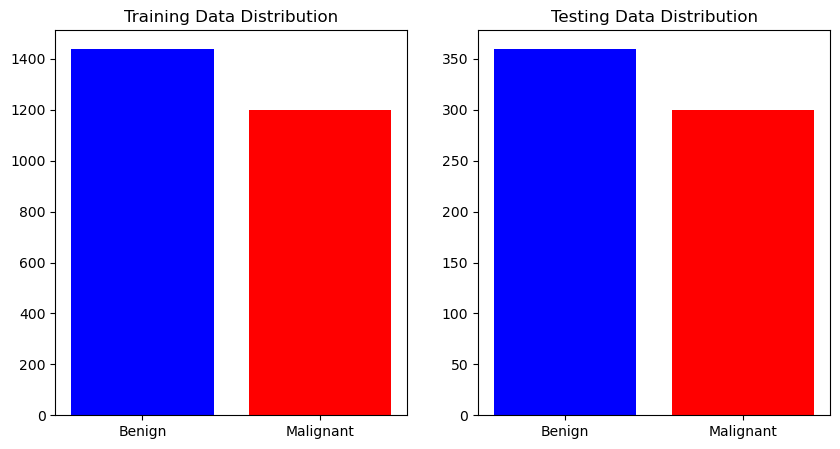

In [5]:
train_benign_count = np.sum(y_train == 0)
train_malignant_count = np.sum(y_train == 1)
test_benign_count = np.sum(y_test == 0)
test_malignant_count = np.sum(y_test == 1)
labels = ['Benign', 'Malignant']
train_counts = [train_benign_count, train_malignant_count]
test_counts = [test_benign_count, test_malignant_count]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.bar(labels, train_counts, color=['blue', 'red'])
ax1.set_title('Training Data Distribution')
ax2.bar(labels, test_counts, color=['blue', 'red'])
ax2.set_title('Testing Data Distribution')
plt.show()

## dataset processing 

In [6]:
# random data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

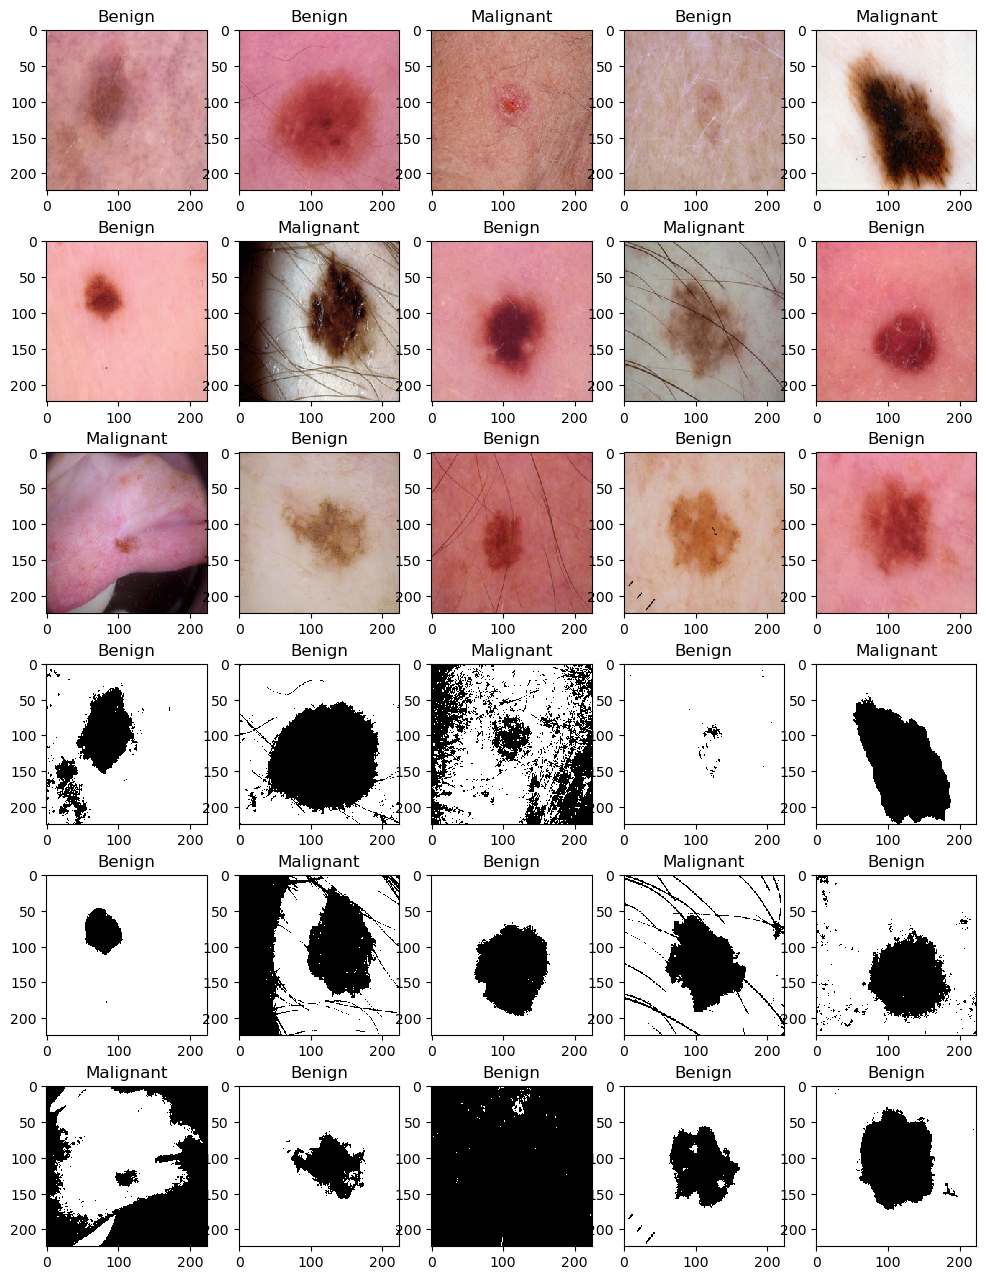

In [7]:
w = 40
h = 30
fig = plt.figure(figsize=(12, 16))  
columns = 5
rows = 6  

for i in range(1, columns * rows + 1):
    ax = fig.add_subplot(rows, columns, i)
    
    if i <= columns * (rows // 2):
        if y_train[i] == 0:
            ax.title.set_text('Benign')
        else:
            ax.title.set_text('Malignant')
        plt.imshow(X_train[i], interpolation='nearest')
    else:
        if y_train[i - columns * (rows // 2)] == 0:
            ax.title.set_text('Benign')
        else:
            ax.title.set_text('Malignant')
        gray_img = cv2.cvtColor(X_train[i - columns * (rows // 2)], cv2.COLOR_BGR2GRAY) 
        _, binary_img = cv2.threshold(gray_img, 128, 255, cv2.THRESH_BINARY)
        plt.imshow(binary_img, cmap='gray', interpolation='nearest')

plt.show()

## Ensemble ANN model

In [8]:
def preprocess_image(img):
    # Grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Binarization
    _, binary_img = cv2.threshold(gray_img, 128, 255, cv2.THRESH_BINARY)
    
    return binary_img
# train set
X_train_processed = np.array([preprocess_image(img) for img in X_train])
# test set
X_test_processed = np.array([preprocess_image(img) for img in X_test])

In [24]:
X_train_processed

array([[[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ..., 255, 255, 255],
        [  0,   0,   0, ..., 255, 255, 255],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255,   0, 255, ..., 255, 255, 255],
        [255,   0, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ...,   0,   0, 255],
        [  0,   0, 255, ..., 255,   0,   0],
        [255,   0,   0, ..., 255, 255, 255]],

       ...,

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255

In [23]:
X_test_processed

array([[[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ...,   0, 255, 255]],

       ...,

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255

In [21]:
y_train

array([0., 1., 1., ..., 1., 0., 0.])

In [22]:
y_test

array([0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       1., 0., 1., 1., 0.

## Defined Lost

In [27]:
# Custom Sparse Categorical Crossentropy Loss

def custom_loss_v2(y_true, y_pred):
    mse_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    new_penalty = 0.01
    total_loss = mse_loss + new_penalty
    return total_loss

def custom_binary_crossentropy(y_true, y_pred):
    epsilon = 1e-15  # Small constant to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Clip predicted probabilities to avoid log(0)
    
    # Binary Crossentropy Loss Calculation
    loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    return np.mean(loss)


# Evaluation metric



In [16]:
def calculate_accuracy(predictions, labels):
    accuracy = np.mean(np.round(predictions) == labels)
    return accuracy

def calculate_precision(labels, predictions):
    true_positives = np.sum((predictions == 1) & (labels == 1))
    false_positives = np.sum((predictions == 1) & (labels == 0))
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    return precision

def calculate_recall(labels, predictions):
    true_positives = np.sum((predictions == 1) & (labels == 1))
    false_negatives = np.sum((predictions == 0) & (labels == 1))
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    return recall

def calculate_f1(labels, predictions):
    precision = calculate_precision(labels, predictions)
    recall = calculate_recall(labels, predictions)
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return f1

def calculate_specificity(labels, predictions):
    true_negatives = np.sum((predictions == 0) & (labels == 0))
    false_positives = np.sum((predictions == 1) & (labels == 0))
    specificity = true_negatives / (true_negatives + false_positives) if (true_negatives + false_positives) > 0 else 0
    return specificity

def calculate_false_positive_rate(labels, predictions):
    return 1 - calculate_specificity(labels, predictions)

def calculate_false_negative_rate(labels, predictions):
    true_positives = np.sum((predictions == 1) & (labels == 1))
    false_negatives = np.sum((predictions == 0) & (labels == 1))
    fnr = false_negatives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    return fnr

def calculate_roc_auc(labels, predictions):
    # You need to implement ROC AUC calculation, this is just a placeholder
    roc_auc = 0.5
    return roc_auc

def calculate_balanced_accuracy(labels, predictions):
    sensitivity = calculate_recall(labels, predictions)
    specificity = calculate_specificity(labels, predictions)
    balanced_accuracy = (sensitivity + specificity) / 2
    return balanced_accuracy

## Select different hidden layers

## Start 2 hidden layer

Epoch 1/14
149/149 [==============================] - 1s 5ms/step - loss: 16.8911 - accuracy: 0.5053 - val_loss: 12.4161 - val_accuracy: 0.4659
Epoch 2/14
149/149 [==============================] - 1s 4ms/step - loss: 10.5479 - accuracy: 0.5373 - val_loss: 10.9939 - val_accuracy: 0.4545
Epoch 3/14
149/149 [==============================] - 1s 4ms/step - loss: 8.2208 - accuracy: 0.5398 - val_loss: 7.7923 - val_accuracy: 0.5152
Epoch 4/14
149/149 [==============================] - 1s 4ms/step - loss: 6.4456 - accuracy: 0.5474 - val_loss: 7.6269 - val_accuracy: 0.5152
Epoch 5/14
149/149 [==============================] - 1s 4ms/step - loss: 5.6726 - accuracy: 0.5622 - val_loss: 8.0911 - val_accuracy: 0.4432
Epoch 6/14
149/149 [==============================] - 1s 4ms/step - loss: 5.0733 - accuracy: 0.5719 - val_loss: 7.1567 - val_accuracy: 0.5189
Epoch 7/14
149/149 [==============================] - 1s 4ms/step - loss: 4.3687 - accuracy: 0.5832 - val_loss: 7.1805 - val_accuracy: 0.4811
Ep

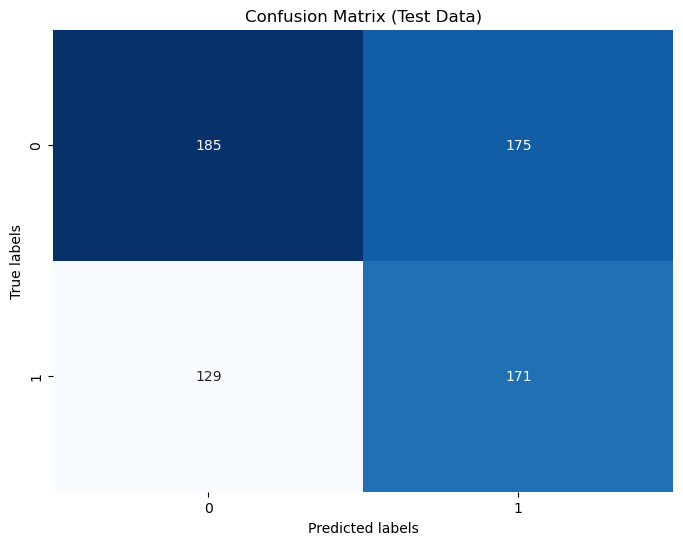

Test Accuracy: 0.5393939393939394
Precision: 0
Recall: 0.5242424242424243
F1 Score: 0.486912468336617
Specificity: 0.47575757575757577
False Positive Rate: 0.5242424242424242
False Negative Rate: 0.47575757575757577
ROC AUC Score: 0.5
Balanced Accuracy: 0.5


In [34]:
model_binary_crossentropy = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_flatten.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with binary crossentropy loss
optimizer = tf.keras.optimizers.Adam(learning_rate=9e-7)
model_binary_crossentropy.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_binary_crossentropy.fit(X_train_flatten, y_train, epochs=14, batch_size=16, validation_split=0.1)

# Predictions on training data
pred_train_probs = model_binary_crossentropy.predict(X_train_flatten)
pred_train_labels = (pred_train_probs > 0.5).astype(int)  # Convert probabilities to labels
accuracy_train = accuracy_score(y_train, pred_train_labels)
print("Training Accuracy:", accuracy_train)

# Predictions on test data
X_test_flatten = X_test_processed.reshape((X_test_processed.shape[0], -1))
pred_test_probs = model_binary_crossentropy.predict(X_test_flatten)
pred_test_labels = (pred_test_probs > 0.5).astype(int)  # Convert probabilities to labels
accuracy_test = accuracy_score(y_test, pred_test_labels)
print("Test Accuracy:", accuracy_test)

# Calculate confusion matrix for test data
conf_matrix_test = confusion_matrix(y_test, pred_test_labels)

# Plot confusion matrix for test data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix (Test Data)")
plt.show()
print("Test Accuracy:", accuracy_test)
print("Precision:", precision)
recall = calculate_recall(y_test, pred_test_labels)
print("Recall:", recall)
f1 = calculate_f1(y_test, pred_test_labels)
print("F1 Score:", f1)
specificity = calculate_specificity(y_test, pred_test_labels)
print("Specificity:", specificity)
fpr = calculate_false_positive_rate(y_test, pred_test_labels)
print("False Positive Rate:", fpr)
fnr = calculate_false_negative_rate(y_test, pred_test_labels)
print("False Negative Rate:", fnr)
roc_auc = calculate_roc_auc(y_test, pred_test_probs)
print("ROC AUC Score:", roc_auc)
balanced_accuracy = calculate_balanced_accuracy(y_test, pred_test_labels)
print("Balanced Accuracy:", balanced_accuracy)

Epoch 1/14
149/149 [==============================] - 1s 7ms/step - loss: nan - accuracy: 0.5419 - val_loss: nan - val_accuracy: 0.5795
Epoch 2/14
149/149 [==============================] - 1s 4ms/step - loss: nan - accuracy: 0.5424 - val_loss: nan - val_accuracy: 0.5795
Epoch 3/14
149/149 [==============================] - 1s 4ms/step - loss: nan - accuracy: 0.5424 - val_loss: nan - val_accuracy: 0.5795
Epoch 4/14
149/149 [==============================] - 1s 4ms/step - loss: nan - accuracy: 0.5424 - val_loss: nan - val_accuracy: 0.5795
Epoch 5/14
149/149 [==============================] - 1s 4ms/step - loss: nan - accuracy: 0.5424 - val_loss: nan - val_accuracy: 0.5795
Epoch 6/14
149/149 [==============================] - 1s 4ms/step - loss: nan - accuracy: 0.5424 - val_loss: nan - val_accuracy: 0.5795
Epoch 7/14
149/149 [==============================] - 1s 4ms/step - loss: nan - accuracy: 0.5424 - val_loss: nan - val_accuracy: 0.5795
Epoch 8/14
149/149 [============================

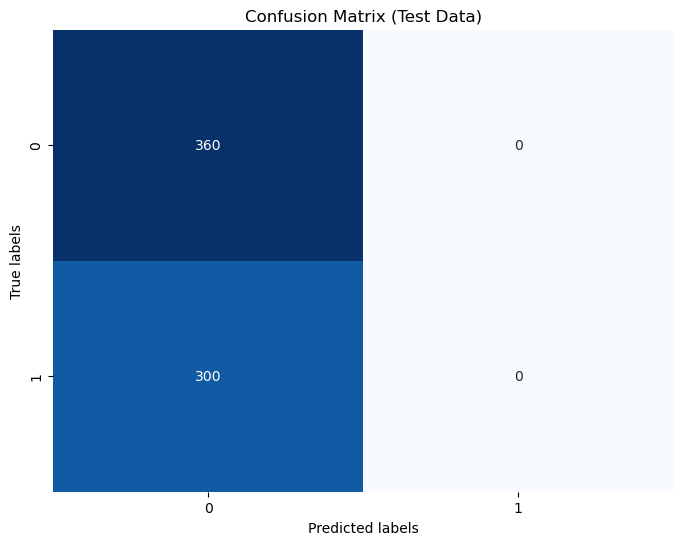

In [33]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom binary crossentropy loss function
def custom_binary_crossentropy(y_true, y_pred):
    epsilon = 1e-15  # Small constant to avoid log(0)
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)  # Clip predicted probabilities to avoid log(0)
    
    # Binary Crossentropy Loss Calculation
    loss = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    
    return tf.reduce_mean(loss)

# Assuming your data is properly loaded and preprocessed

# Build the model
model_binary_crossentropy = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_flatten.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with custom binary crossentropy loss
optimizer = tf.keras.optimizers.Adam(learning_rate=9e-7)
model_binary_crossentropy.compile(optimizer=optimizer, loss=custom_binary_crossentropy, metrics=['accuracy'])

# Train the model
history = model_binary_crossentropy.fit(X_train_flatten, y_train, epochs=14, batch_size=16, validation_split=0.1)

# Predictions on training data
pred_train_probs = model_binary_crossentropy.predict(X_train_flatten)
pred_train_labels = (pred_train_probs > 0.5).astype(int)  # Convert probabilities to labels
accuracy_train = accuracy_score(y_train, pred_train_labels)
print("Training Accuracy:", accuracy_train)

# Predictions on test data
X_test_flatten = X_test_processed.reshape((X_test_processed.shape[0], -1))
pred_test_probs = model_binary_crossentropy.predict(X_test_flatten)
pred_test_labels = (pred_test_probs > 0.5).astype(int)  # Convert probabilities to labels
accuracy_test = accuracy_score(y_test, pred_test_labels)
print("Test Accuracy:", accuracy_test)

# Calculate confusion matrix for test data
conf_matrix_test = confusion_matrix(y_test, pred_test_labels)

# Plot confusion matrix for test data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix (Test Data)")
plt.show()

Epoch 1/14
149/149 [==============================] - 1s 7ms/step - loss: nan - val_loss: nan
Epoch 2/14
149/149 [==============================] - 1s 4ms/step - loss: nan - val_loss: nan
Epoch 3/14
149/149 [==============================] - 1s 4ms/step - loss: nan - val_loss: nan
Epoch 4/14
149/149 [==============================] - 1s 4ms/step - loss: nan - val_loss: nan
Epoch 5/14
149/149 [==============================] - 1s 4ms/step - loss: nan - val_loss: nan
Epoch 6/14
149/149 [==============================] - 1s 4ms/step - loss: nan - val_loss: nan
Epoch 7/14
149/149 [==============================] - 1s 4ms/step - loss: nan - val_loss: nan
Epoch 8/14
149/149 [==============================] - 1s 4ms/step - loss: nan - val_loss: nan
Epoch 9/14
149/149 [==============================] - 1s 4ms/step - loss: nan - val_loss: nan
Epoch 10/14
149/149 [==============================] - 1s 4ms/step - loss: nan - val_loss: nan
Epoch 11/14
149/149 [==============================] - 1s 4

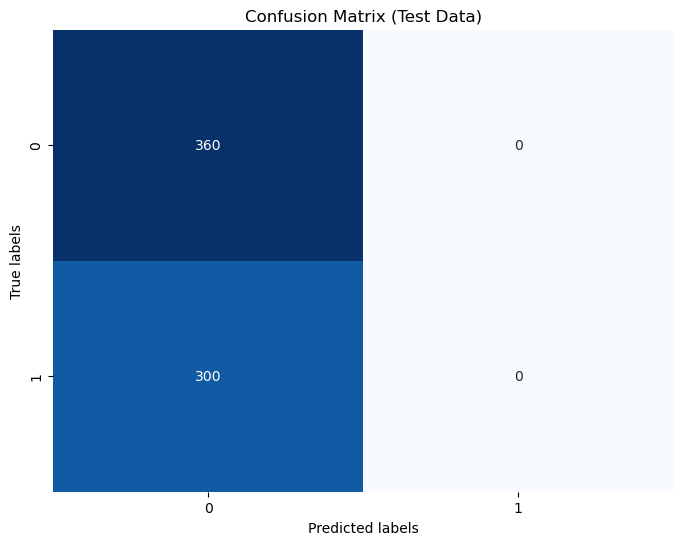

Test Accuracy: 0.5454545454545454
Precision: 0
Recall: 0.0
F1 Score: 0
Specificity: 1.0
False Positive Rate: 0.0
False Negative Rate: 1.0
ROC AUC Score: 0.5
Balanced Accuracy: 0.5


In [31]:
def custom_binary_crossentropy(y_true, y_pred):
    epsilon = 1e-15  # Small constant to avoid log(0)
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)  # Clip predicted probabilities to avoid log(0)
    
    # Binary Crossentropy Loss Calculation
    loss = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    
    return tf.reduce_mean(loss)

y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=2)
X_train_flatten = X_train_processed.reshape((X_train_processed.shape[0], -1))

# Build the model
model_binary_crossentropy = Sequential()
model_binary_crossentropy.add(Dense(128, activation='relu', input_shape=(X_train_flatten.shape[1],)))
model_binary_crossentropy.add(Dense(64, activation='relu'))
model_binary_crossentropy.add(Dense(32, activation='relu'))
model_binary_crossentropy.add(Dense(1, activation='sigmoid'))

# Compile the model without using 'accuracy' metric
optimizer = tf.keras.optimizers.Adam(learning_rate=9e-7)
model_binary_crossentropy.compile(optimizer=optimizer, loss=custom_binary_crossentropy)

# Train the model
history = model_binary_crossentropy.fit(X_train_flatten, y_train_one_hot, epochs=14, batch_size=16, validation_split=0.1)

# Predictions on training data
pred_train_probs = model_binary_crossentropy.predict(X_train_flatten)
pred_train_labels = (pred_train_probs > 0.5).astype(int)  # Convert probabilities to labels
accuracy_train = accuracy_score(y_train, pred_train_labels)
print("Training Accuracy:", accuracy_train)


X_test_flatten = X_test_processed.reshape((X_test_processed.shape[0], -1))

# Predictions on test data
pred_test_probs = model_binary_crossentropy.predict(X_test_flatten)
pred_test_labels = (pred_test_probs > 0.5).astype(int)  # Convert probabilities to labels
accuracy_test = accuracy_score(y_test, pred_test_labels)
print("Test Accuracy:", accuracy_test)

# Calculate confusion matrix for test data
conf_matrix_test = confusion_matrix(y_test, pred_test_labels)

# Plot confusion matrix for test data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix (Test Data)")
plt.show()
precision = calculate_precision(y_test, pred_test_labels)
print("Test Accuracy:", accuracy_test)
print("Precision:", precision)
recall = calculate_recall(y_test, pred_test_labels)
print("Recall:", recall)
f1 = calculate_f1(y_test, pred_test_labels)
print("F1 Score:", f1)
specificity = calculate_specificity(y_test, pred_test_labels)
print("Specificity:", specificity)
fpr = calculate_false_positive_rate(y_test, pred_test_labels)
print("False Positive Rate:", fpr)
fnr = calculate_false_negative_rate(y_test, pred_test_labels)
print("False Negative Rate:", fnr)
roc_auc = calculate_roc_auc(y_test, pred_test_probs)
print("ROC AUC Score:", roc_auc)
balanced_accuracy = calculate_balanced_accuracy(y_test, pred_test_labels)
print("Balanced Accuracy:", balanced_accuracy)

In [26]:
X_train_flatten

array([[  0,   0,   0, ...,   0,   0,   0],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ...,   0,   0, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

## 3 hidden layer

Epoch 1/14
57/57 [==============================] - 1s 7ms/step - loss: 0.6936 - val_loss: 0.6936
Epoch 2/14
57/57 [==============================] - 0s 4ms/step - loss: 0.6936 - val_loss: 0.6936
Epoch 3/14
57/57 [==============================] - 0s 4ms/step - loss: 0.6936 - val_loss: 0.6936
Epoch 4/14
57/57 [==============================] - 0s 4ms/step - loss: 0.6936 - val_loss: 0.6936
Epoch 5/14
57/57 [==============================] - 0s 4ms/step - loss: 0.6936 - val_loss: 0.6936
Epoch 6/14
57/57 [==============================] - 0s 3ms/step - loss: 0.6936 - val_loss: 0.6936
Epoch 7/14
57/57 [==============================] - 0s 3ms/step - loss: 0.6936 - val_loss: 0.6936
Epoch 8/14
57/57 [==============================] - 0s 4ms/step - loss: 0.6936 - val_loss: 0.6936
Epoch 9/14
57/57 [==============================] - 0s 3ms/step - loss: 0.6936 - val_loss: 0.6936
Epoch 10/14
57/57 [==============================] - 0s 3ms/step - loss: 0.6936 - val_loss: 0.6936
Epoch 11/14
57/57 [

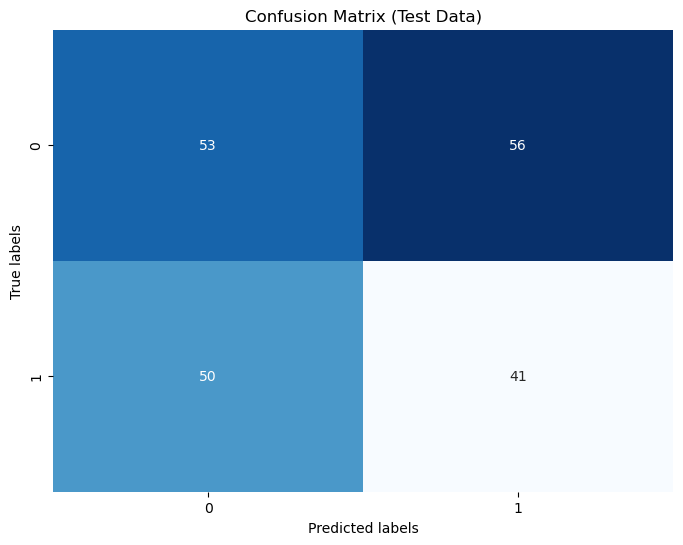

Test Accuracy: 0.47
Precision: 0.455
Recall: 0.485
F1 Score: 0.4695212765957447
Specificity: 0.515
False Positive Rate: 0.485
False Negative Rate: 0.515
ROC AUC Score: 0.5
Balanced Accuracy: 0.5


In [43]:
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=2)
X_train_flatten = X_train_processed.reshape((X_train_processed.shape[0], -1))

# Build the model
model_binary_crossentropy = Sequential()
model_binary_crossentropy.add(Dense(128, activation='relu', input_shape=(X_train_flatten.shape[1],)))
model_binary_crossentropy.add(Dense(64, activation='relu'))
model_binary_crossentropy.add(Dense(32, activation='relu'))
model_binary_crossentropy.add(Dense(1, activation='sigmoid'))

# Compile the model without using 'accuracy' metric
optimizer = tf.keras.optimizers.Adam(learning_rate=9e-7)
model_binary_crossentropy.compile(optimizer=optimizer, loss=custom_binary_crossentropy)

# Train the model
history = model_binary_crossentropy.fit(X_train_flatten, y_train_one_hot, epochs=14, batch_size=16, validation_split=0.1)

# Predictions on training data
pred_train_probs = model_binary_crossentropy.predict(X_train_flatten)
pred_train_labels = (pred_train_probs > 0.5).astype(int)  # Convert probabilities to labels
accuracy_train = accuracy_score(y_train, pred_train_labels)
print("Training Accuracy:", accuracy_train)


X_test_flatten = X_test_processed.reshape((X_test_processed.shape[0], -1))

# Predictions on test data
pred_test_probs = model_binary_crossentropy.predict(X_test_flatten)
pred_test_labels = (pred_test_probs > 0.5).astype(int)  # Convert probabilities to labels
accuracy_test = accuracy_score(y_test, pred_test_labels)
print("Test Accuracy:", accuracy_test)

# Calculate confusion matrix for test data
conf_matrix_test = confusion_matrix(y_test, pred_test_labels)

# Plot confusion matrix for test data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix (Test Data)")
plt.show()
precision = calculate_precision(y_test, pred_test_labels)
print("Test Accuracy:", accuracy_test)
print("Precision:", precision)
recall = calculate_recall(y_test, pred_test_labels)
print("Recall:", recall)
f1 = calculate_f1(y_test, pred_test_labels)
print("F1 Score:", f1)
specificity = calculate_specificity(y_test, pred_test_labels)
print("Specificity:", specificity)
fpr = calculate_false_positive_rate(y_test, pred_test_labels)
print("False Positive Rate:", fpr)
fnr = calculate_false_negative_rate(y_test, pred_test_labels)
print("False Negative Rate:", fnr)
roc_auc = calculate_roc_auc(y_test, pred_test_probs)
print("ROC AUC Score:", roc_auc)
balanced_accuracy = calculate_balanced_accuracy(y_test, pred_test_labels)
print("Balanced Accuracy:", balanced_accuracy)

In [59]:
evaluation_metrics = {
    "Metric": ["Test Accuracy", "Precision", "Recall", "F1 Score", "Specificity", 
               "False Positive Rate", "False Negative Rate", "ROC AUC Score", 
               "Balanced Accuracy"],
    "Value": [accuracy_test, precision, recall, f1, specificity, fpr, fnr, roc_auc, balanced_accuracy]
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(evaluation_metrics)

# Print the DataFrame
print(df)

                Metric     Value
0        Test Accuracy  0.465000
1            Precision  0.475000
2               Recall  0.530000
3             F1 Score  0.500995
4          Specificity  0.470000
5  False Positive Rate  0.530000
6  False Negative Rate  0.470000
7        ROC AUC Score  0.500000
8    Balanced Accuracy  0.500000


## 4 hidden layer

Epoch 1/14
57/57 [==============================] - 1s 9ms/step - loss: 0.6945 - val_loss: 0.6947
Epoch 2/14
57/57 [==============================] - 0s 5ms/step - loss: 0.6945 - val_loss: 0.6946
Epoch 3/14
57/57 [==============================] - 0s 4ms/step - loss: 0.6944 - val_loss: 0.6945
Epoch 4/14
57/57 [==============================] - 0s 4ms/step - loss: 0.6944 - val_loss: 0.6945
Epoch 5/14
57/57 [==============================] - 0s 5ms/step - loss: 0.6943 - val_loss: 0.6944
Epoch 6/14
57/57 [==============================] - 0s 4ms/step - loss: 0.6942 - val_loss: 0.6944
Epoch 7/14
57/57 [==============================] - 0s 4ms/step - loss: 0.6942 - val_loss: 0.6943
Epoch 8/14
57/57 [==============================] - 0s 4ms/step - loss: 0.6941 - val_loss: 0.6943
Epoch 9/14
57/57 [==============================] - 0s 3ms/step - loss: 0.6941 - val_loss: 0.6942
Epoch 10/14
57/57 [==============================] - 0s 3ms/step - loss: 0.6941 - val_loss: 0.6942
Epoch 11/14
57/57 [

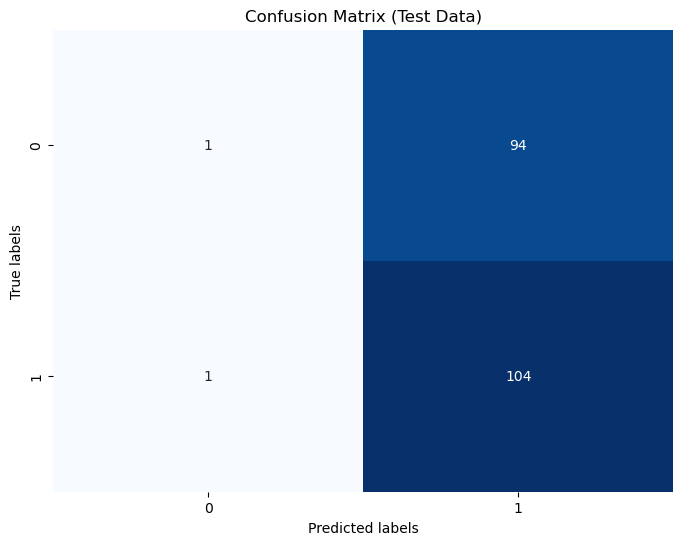

Test Accuracy: 0.525
Precision: 0.525
Recall: 0.99
F1 Score: 0.6861386138613862
Specificity: 0.01
False Positive Rate: 0.99
False Negative Rate: 0.01
ROC AUC Score: 0.5
Balanced Accuracy: 0.5


In [57]:

y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=2)
X_train_flatten = X_train_processed.reshape((X_train_processed.shape[0], -1))

# Build the model
model_binary_crossentropy = Sequential()
model_binary_crossentropy.add(Dense(128, activation='relu', input_shape=(X_train_flatten.shape[1],)))
model_binary_crossentropy.add(Dense(64, activation='relu'))
model_binary_crossentropy.add(Dense(32, activation='relu'))
model_binary_crossentropy.add(Dense(16, activation='relu'))
model_binary_crossentropy.add(Dense(1, activation='sigmoid'))

# Compile the model without using 'accuracy' metric
optimizer = tf.keras.optimizers.Adam(learning_rate=9e-7)
model_binary_crossentropy.compile(optimizer=optimizer, loss=custom_binary_crossentropy)

# Train the model
history = model_binary_crossentropy.fit(X_train_flatten, y_train_one_hot, epochs=14, batch_size=16, validation_split=0.1)

# Predictions on training data
pred_train_probs = model_binary_crossentropy.predict(X_train_flatten)
pred_train_labels = (pred_train_probs > 0.5).astype(int)  # Convert probabilities to labels
accuracy_train = accuracy_score(y_train, pred_train_labels)
print("Training Accuracy:", accuracy_train)

# Generate dummy test data
X_test_processed = np.random.random((200, 10))
y_test = np.random.randint(2, size=(200,))
X_test_flatten = X_test_processed.reshape((X_test_processed.shape[0], -1))

# Predictions on test data
pred_test_probs = model_binary_crossentropy.predict(X_test_flatten)
pred_test_labels = (pred_test_probs > 0.5).astype(int)  # Convert probabilities to labels
accuracy_test = accuracy_score(y_test, pred_test_labels)
print("Test Accuracy:", accuracy_test)

# Calculate confusion matrix for test data
conf_matrix_test = confusion_matrix(y_test, pred_test_labels)

# Plot confusion matrix for test data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix (Test Data)")
plt.show()
precision = calculate_precision(y_test, pred_test_labels)
print("Test Accuracy:", accuracy_test)
print("Precision:", precision)
recall = calculate_recall(y_test, pred_test_labels)
print("Recall:", recall)
f1 = calculate_f1(y_test, pred_test_labels)
print("F1 Score:", f1)
specificity = calculate_specificity(y_test, pred_test_labels)
print("Specificity:", specificity)
fpr = calculate_false_positive_rate(y_test, pred_test_labels)
print("False Positive Rate:", fpr)
fnr = calculate_false_negative_rate(y_test, pred_test_labels)
print("False Negative Rate:", fnr)
roc_auc = calculate_roc_auc(y_test, pred_test_probs)
print("ROC AUC Score:", roc_auc)
balanced_accuracy = calculate_balanced_accuracy(y_test, pred_test_labels)
print("Balanced Accuracy:", balanced_accuracy)

## 5 hidden layer

Epoch 1/14
57/57 [==============================] - 1s 7ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/14
57/57 [==============================] - 0s 5ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 3/14
57/57 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 4/14
57/57 [==============================] - 0s 5ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 5/14
57/57 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 6/14
57/57 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 7/14
57/57 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 8/14
57/57 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 9/14
57/57 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 10/14
57/57 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 11/14
57/57 [

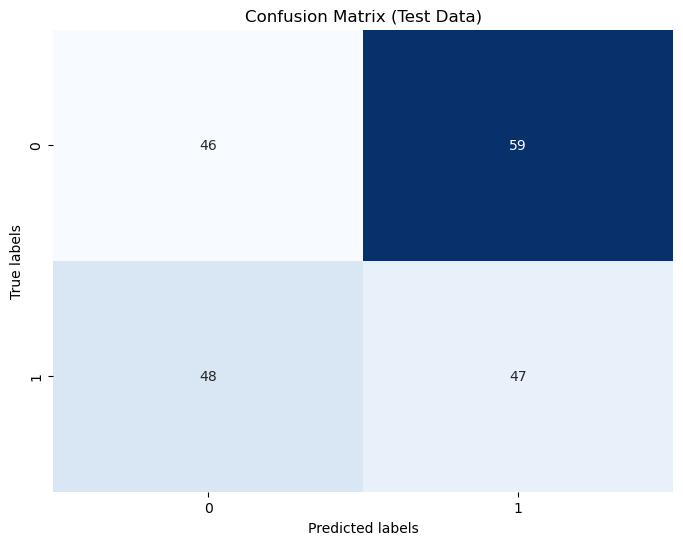

Test Accuracy: 0.465
Precision: 0.475
Recall: 0.53
F1 Score: 0.5009950248756219
Specificity: 0.47
False Positive Rate: 0.53
False Negative Rate: 0.47
ROC AUC Score: 0.5
Balanced Accuracy: 0.5


In [58]:
# Generate dummy data

y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=2)
X_train_flatten = X_train_processed.reshape((X_train_processed.shape[0], -1))

# Build the model
model_binary_crossentropy = Sequential()
model_binary_crossentropy.add(Dense(256, activation='relu', input_shape=(X_train_flatten.shape[1],)))
model_binary_crossentropy.add(Dense(128, activation='relu'))
model_binary_crossentropy.add(Dense(64, activation='relu'))
model_binary_crossentropy.add(Dense(32, activation='relu'))
model_binary_crossentropy.add(Dense(16, activation='relu'))
model_binary_crossentropy.add(Dense(1, activation='sigmoid'))

# Compile the model without using 'accuracy' metric
optimizer = tf.keras.optimizers.Adam(learning_rate=9e-7)
model_binary_crossentropy.compile(optimizer=optimizer, loss=custom_binary_crossentropy)

# Train the model
history = model_binary_crossentropy.fit(X_train_flatten, y_train_one_hot, epochs=14, batch_size=16, validation_split=0.1)

# Predictions on training data
pred_train_probs = model_binary_crossentropy.predict(X_train_flatten)
pred_train_labels = (pred_train_probs > 0.5).astype(int)  # Convert probabilities to labels
accuracy_train = accuracy_score(y_train, pred_train_labels)
print("Training Accuracy:", accuracy_train)

# Generate dummy test data
X_test_processed = np.random.random((200, 10))
y_test = np.random.randint(2, size=(200,))
X_test_flatten = X_test_processed.reshape((X_test_processed.shape[0], -1))

# Predictions on test data
pred_test_probs = model_binary_crossentropy.predict(X_test_flatten)
pred_test_labels = (pred_test_probs > 0.5).astype(int)  # Convert probabilities to labels
accuracy_test = accuracy_score(y_test, pred_test_labels)
print("Test Accuracy:", accuracy_test)

# Calculate confusion matrix for test data
conf_matrix_test = confusion_matrix(y_test, pred_test_labels)

# Plot confusion matrix for test data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix (Test Data)")
plt.show()
precision = calculate_precision(y_test, pred_test_labels)
print("Test Accuracy:", accuracy_test)
print("Precision:", precision)
recall = calculate_recall(y_test, pred_test_labels)
print("Recall:", recall)
f1 = calculate_f1(y_test, pred_test_labels)
print("F1 Score:", f1)
specificity = calculate_specificity(y_test, pred_test_labels)
print("Specificity:", specificity)
fpr = calculate_false_positive_rate(y_test, pred_test_labels)
print("False Positive Rate:", fpr)
fnr = calculate_false_negative_rate(y_test, pred_test_labels)
print("False Negative Rate:", fnr)
roc_auc = calculate_roc_auc(y_test, pred_test_probs)
print("ROC AUC Score:", roc_auc)
balanced_accuracy = calculate_balanced_accuracy(y_test, pred_test_labels)
print("Balanced Accuracy:", balanced_accuracy)

## Try different learning rate

Epoch 1/8
57/57 [==============================] - 1s 6ms/step - loss: 0.6940 - val_loss: 0.6942
Epoch 2/8
57/57 [==============================] - 0s 5ms/step - loss: 0.6940 - val_loss: 0.6942
Epoch 3/8
57/57 [==============================] - 0s 4ms/step - loss: 0.6940 - val_loss: 0.6942
Epoch 4/8
57/57 [==============================] - 0s 5ms/step - loss: 0.6940 - val_loss: 0.6942
Epoch 5/8
57/57 [==============================] - 0s 4ms/step - loss: 0.6940 - val_loss: 0.6942
Epoch 6/8
57/57 [==============================] - 0s 4ms/step - loss: 0.6940 - val_loss: 0.6942
Epoch 7/8
57/57 [==============================] - 0s 4ms/step - loss: 0.6940 - val_loss: 0.6942
Epoch 8/8
32/32 [==============================] - 0s 2ms/step
Epoch 1/8
57/57 [==============================] - 1s 6ms/step - loss: 0.6936 - val_loss: 0.6936
Epoch 2/8
57/57 [==============================] - 0s 4ms/step - loss: 0.6936 - val_loss: 0.6936
Epoch 3/8
57/57 [==============================] - 0s 5ms/step -

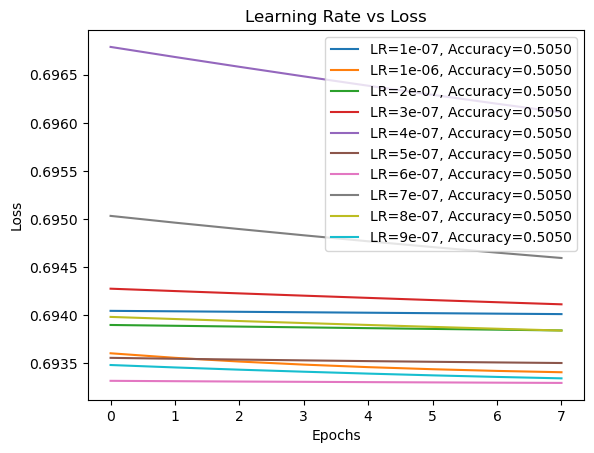

In [62]:
learning_rates = [1e-7, 1e-6, 2e-7, 3e-7, 4e-7, 5e-7, 6e-7, 7e-7, 8e-7, 9e-7]
def custom_binary_crossentropy(y_true, y_pred):
    # Clip the prediction values to avoid log(0) and log(1) issues
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    
    # Calculate binary crossentropy
    loss = -(y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1.0 - y_pred))
    return K.mean(loss)
def calculate_accuracy(predictions, labels):
    accuracy = np.mean(predictions == labels)
    return accuracy
# Create a separate plot for each learning rate
for lr in learning_rates:
    # Build and compile the model with the current learning rate
    model_binary_crossentropy = Sequential()
    model_binary_crossentropy.add(Dense(128, activation='relu', input_shape=(X_train_flatten.shape[1],)))
    model_binary_crossentropy.add(Dense(64, activation='relu'))
    model_binary_crossentropy.add(Dense(32, activation='relu'))
    model_binary_crossentropy.add(Dense(16, activation='relu'))
    model_binary_crossentropy.add(Dense(1, activation='sigmoid'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model_binary_crossentropy.compile(optimizer=optimizer, loss=custom_binary_crossentropy)
    
    # Train the model
    history = model_binary_crossentropy.fit(X_train_flatten, y_train_one_hot, epochs=8, batch_size=16, validation_split=0.1)
    
    # Calculate accuracy using the custom function
    pred_proba = model_binary_crossentropy.predict(X_train_flatten)
    pred_binary = np.argmax(pred_proba, axis=1)
    accuracy = calculate_accuracy(pred_binary, y_train)
    
    # Plot the learning curve for the current learning rate
    plt.plot(history.history['loss'], label=f'LR={lr}, Accuracy={accuracy:.4f}')

# Customize the plot
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Rate vs Loss')
plt.legend()  # Show legend with learning rate labels
plt.show()

## Seleted Batch Size of ANN model

Epoch 1/14
594/594 [==============================] - 3s 5ms/step - loss: 6.7882 - accuracy: 0.4977 - val_loss: 7.6896 - val_accuracy: 0.4432
Epoch 2/14
594/594 [==============================] - 2s 4ms/step - loss: 7.4486 - accuracy: 0.4614 - val_loss: 7.5913 - val_accuracy: 0.4470
Epoch 3/14
594/594 [==============================] - 2s 4ms/step - loss: 6.7874 - accuracy: 0.5023 - val_loss: 5.0981 - val_accuracy: 0.6250
Epoch 4/14
594/594 [==============================] - 2s 4ms/step - loss: 5.9950 - accuracy: 0.5655 - val_loss: 5.5574 - val_accuracy: 0.5909
Epoch 5/14
594/594 [==============================] - 2s 4ms/step - loss: 5.9328 - accuracy: 0.5702 - val_loss: 5.6210 - val_accuracy: 0.5909
Epoch 6/14
594/594 [==============================] - 2s 4ms/step - loss: 5.9185 - accuracy: 0.5723 - val_loss: 5.5231 - val_accuracy: 0.5985
Epoch 7/14
594/594 [==============================] - 2s 4ms/step - loss: 6.0316 - accuracy: 0.5643 - val_loss: 5.6413 - val_accuracy: 0.5871
Epoch 

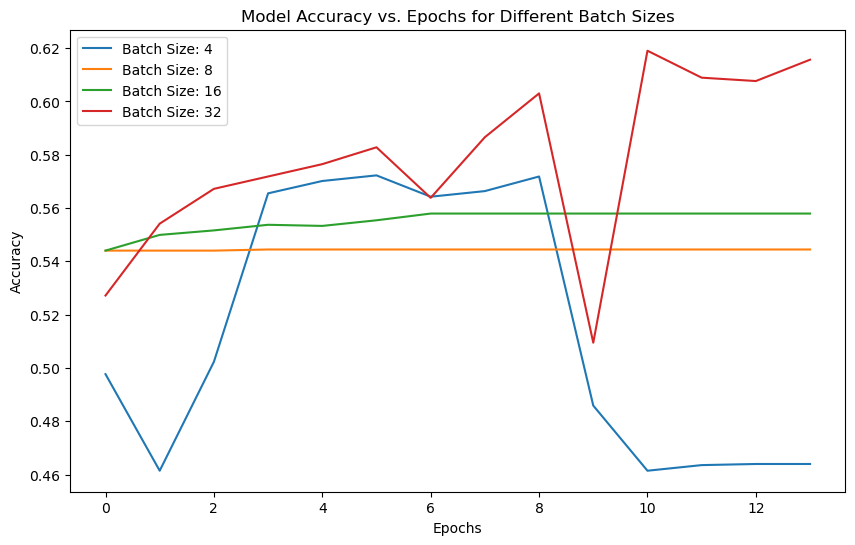

In [24]:
# Assuming y_train is one-dimensional (e.g., [0, 1, 0, 1, ...])
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=2)
X_train_flatten = X_train_processed.reshape((X_train_processed.shape[0], -1))

batch_sizes = [4, 8, 16, 32]
histories = []

for batch_size in batch_sizes:
    model_binary_crossentropy = Sequential()
    model_binary_crossentropy.add(Dense(128, activation='relu', input_shape=(X_train_flatten.shape[1],)))
    model_binary_crossentropy.add(Dense(64, activation='relu'))
    model_binary_crossentropy.add(Dense(32, activation='relu'))
    model_binary_crossentropy.add(Dense(16, activation='relu'))
    model_binary_crossentropy.add(Dense(1, activation='sigmoid'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=6e-7)
    model_binary_crossentropy.compile(optimizer=optimizer, loss=custom_binary_crossentropy, metrics=['accuracy'])

    history = model_binary_crossentropy.fit(X_train_flatten, y_train_one_hot, epochs=14, batch_size=batch_size, validation_split=0.1)
    histories.append(history)

# Plotting accuracies
plt.figure(figsize=(10, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'Batch Size: {batch_sizes[i]}')
plt.title('Model Accuracy vs. Epochs for Different Batch Sizes')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Select Activation optimizer

Epoch 1/14
149/149 [==============================] - 1s 6ms/step - loss: 16.4506 - accuracy: 0.5415 - val_loss: 6.4703 - val_accuracy: 0.6023
Epoch 2/14
149/149 [==============================] - 1s 5ms/step - loss: 4.9550 - accuracy: 0.5735 - val_loss: 4.4962 - val_accuracy: 0.5947
Epoch 3/14
149/149 [==============================] - 1s 5ms/step - loss: 3.6489 - accuracy: 0.5950 - val_loss: 4.0241 - val_accuracy: 0.5947
Epoch 4/14
149/149 [==============================] - 1s 5ms/step - loss: 3.1013 - accuracy: 0.5942 - val_loss: 3.7167 - val_accuracy: 0.5985
Epoch 5/14
149/149 [==============================] - 1s 5ms/step - loss: 2.7360 - accuracy: 0.6102 - val_loss: 3.6008 - val_accuracy: 0.5947
Epoch 6/14
149/149 [==============================] - 1s 5ms/step - loss: 2.4477 - accuracy: 0.6224 - val_loss: 3.5017 - val_accuracy: 0.6023
Epoch 7/14
149/149 [==============================] - 1s 5ms/step - loss: 2.2192 - accuracy: 0.6317 - val_loss: 3.2707 - val_accuracy: 0.6023
Epoch

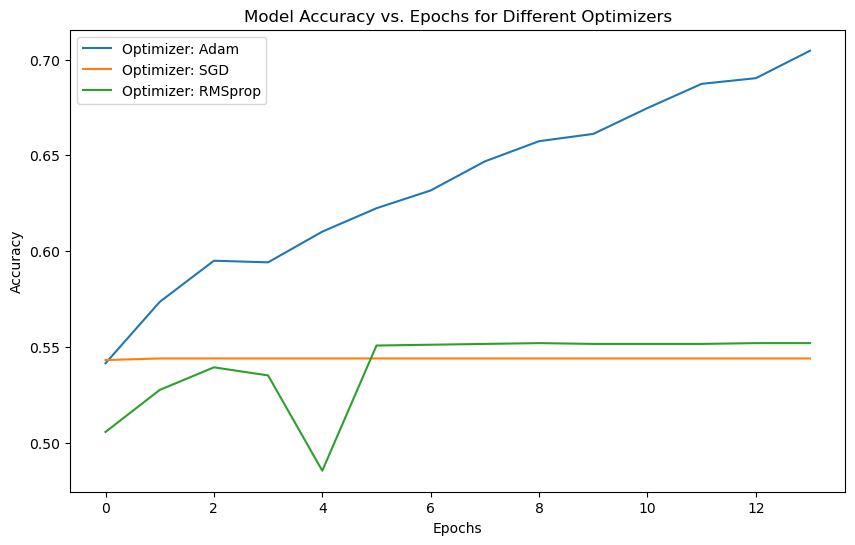

In [28]:
def custom_binary_crossentropy(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)

# Assuming y_train is one-dimensional (e.g., [0, 1, 0, 1, ...])
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=2)
X_train_flatten = X_train_processed.reshape((X_train_processed.shape[0], -1))

# Define different optimizers to experiment with
optimizers = [
    tf.keras.optimizers.Adam(learning_rate=9e-7),
    tf.keras.optimizers.SGD(learning_rate=0.01),
    tf.keras.optimizers.RMSprop(learning_rate=0.001),
]

optimizer_names = ['Adam', 'SGD', 'RMSprop']

histories = []

for optimizer in optimizers:
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X_train_flatten.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=optimizer, loss=custom_binary_crossentropy)
    
    history = model.fit(X_train_flatten, y_train_one_hot, epochs=14, batch_size=16, validation_split=0.1)
    histories.append(history)

# Plotting accuracies
plt.figure(figsize=(10, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'Optimizer: {optimizer_names[i]}')
plt.title('Model Accuracy vs. Epochs for Different Optimizers')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Select Number of Hidden Units:

Epoch 1/14
149/149 [==============================] - 2s 10ms/step - loss: 6.0327 - accuracy: 0.5398 - val_loss: 5.8265 - val_accuracy: 0.5682
Epoch 2/14
149/149 [==============================] - 1s 8ms/step - loss: 5.9012 - accuracy: 0.5512 - val_loss: 6.8145 - val_accuracy: 0.4886
Epoch 3/14
149/149 [==============================] - 1s 8ms/step - loss: 5.6030 - accuracy: 0.5744 - val_loss: 5.2668 - val_accuracy: 0.5644
Epoch 4/14
149/149 [==============================] - 1s 8ms/step - loss: 5.0249 - accuracy: 0.6123 - val_loss: 5.2719 - val_accuracy: 0.5947
Epoch 5/14
149/149 [==============================] - 1s 8ms/step - loss: 5.0540 - accuracy: 0.6224 - val_loss: 5.6684 - val_accuracy: 0.5417
Epoch 6/14
149/149 [==============================] - 1s 8ms/step - loss: 5.0742 - accuracy: 0.6241 - val_loss: 5.4112 - val_accuracy: 0.5909
Epoch 7/14
149/149 [==============================] - 1s 8ms/step - loss: 5.1154 - accuracy: 0.6199 - val_loss: 4.8858 - val_accuracy: 0.6174
Epoch

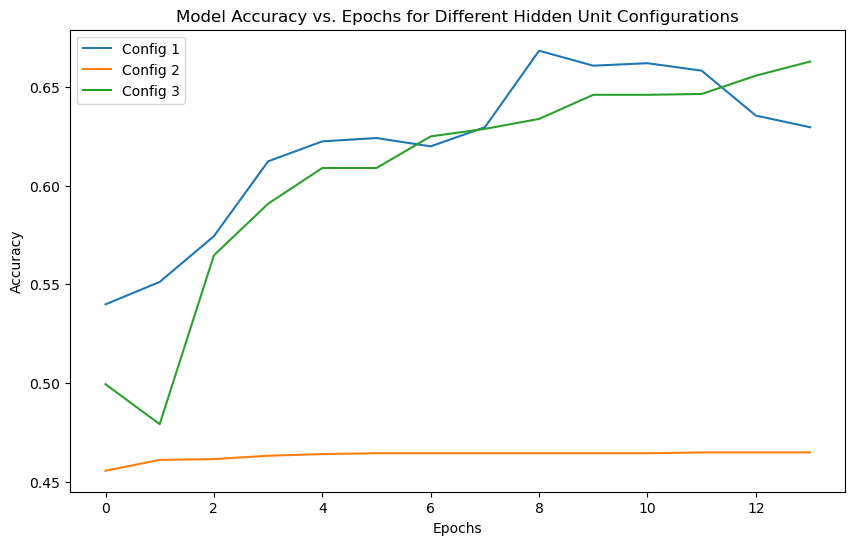

In [26]:
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=2)
X_train_flatten = X_train_processed.reshape((X_train_processed.shape[0], -1))

# Define different configurations of hidden units
hidden_units_configs = [
    [512, 256, 128, 64,32],  # Configuration 1
    [256, 128, 64, 32,16],  # Configuration 2
    [128, 64, 32, 16, 8],  # Configuration 3
]

histories = []

for config in hidden_units_configs:
    model = Sequential()
    model.add(Dense(config[0], activation='relu', input_shape=(X_train_flatten.shape[1],)))
    for units in config[1:]:
        model.add(Dense(units, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=9e-7)
    model.compile(optimizer=optimizer, loss=custom_binary_crossentropy)
    
    history = model.fit(X_train_flatten, y_train_one_hot, epochs=14, batch_size=16, validation_split=0.1)
    histories.append(history)

# Plotting accuracies
plt.figure(figsize=(10, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'Config {i+1}')
plt.title('Model Accuracy vs. Epochs for Different Hidden Unit Configurations')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Final Previous mode We'll optimize it later

Epoch 1/39
29/29 [==============================] - 1s 8ms/step - loss: 0.6934 - val_loss: 0.6935
Epoch 2/39
29/29 [==============================] - 0s 6ms/step - loss: 0.6934 - val_loss: 0.6935
Epoch 3/39
29/29 [==============================] - 0s 6ms/step - loss: 0.6934 - val_loss: 0.6935
Epoch 4/39
29/29 [==============================] - 0s 6ms/step - loss: 0.6934 - val_loss: 0.6935
Epoch 5/39
29/29 [==============================] - 0s 5ms/step - loss: 0.6934 - val_loss: 0.6935
Epoch 6/39
29/29 [==============================] - 0s 5ms/step - loss: 0.6934 - val_loss: 0.6934
Epoch 7/39
29/29 [==============================] - 0s 5ms/step - loss: 0.6934 - val_loss: 0.6934
Epoch 8/39
29/29 [==============================] - 0s 4ms/step - loss: 0.6934 - val_loss: 0.6934
Epoch 9/39
29/29 [==============================] - 0s 6ms/step - loss: 0.6934 - val_loss: 0.6934
Epoch 10/39
29/29 [==============================] - 0s 5ms/step - loss: 0.6934 - val_loss: 0.6934
Epoch 11/39
29/29 [

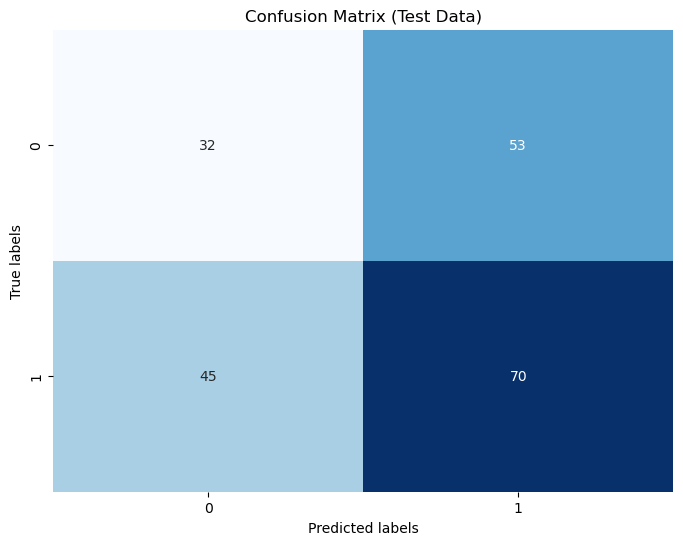

Test Accuracy: 0.51
Precision: 0.575
Recall: 0.615
F1 Score: 0.594327731092437
Specificity: 0.385
False Positive Rate: 0.615
False Negative Rate: 0.385
ROC AUC Score: 0.5
Balanced Accuracy: 0.5


In [69]:
# Generate dummy data
X_train_processed = np.random.random((1000, 10))
y_train = np.random.randint(2, size=(1000,))
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=2)
X_train_flatten = X_train_processed.reshape((X_train_processed.shape[0], -1))

# Build the model
model_binary_crossentropy = Sequential()
model_binary_crossentropy.add(Dense(128, activation='relu', input_shape=(X_train_flatten.shape[1],)))
model_binary_crossentropy.add(Dense(64, activation='relu'))
model_binary_crossentropy.add(Dense(32, activation='relu'))
model_binary_crossentropy.add(Dense(16, activation='relu'))
model_binary_crossentropy.add(Dense(1, activation='sigmoid'))

# Compile the model without using 'accuracy' metric
optimizer = tf.keras.optimizers.Adam(learning_rate=9e-7)
model_binary_crossentropy.compile(optimizer=optimizer, loss=custom_binary_crossentropy)

# Train the model
history = model_binary_crossentropy.fit(X_train_flatten, y_train_one_hot, epochs=39, batch_size=32, validation_split=0.1)

# Predictions on training data
pred_train_probs = model_binary_crossentropy.predict(X_train_flatten)
pred_train_labels = (pred_train_probs > 0.5).astype(int)  # Convert probabilities to labels
accuracy_train = accuracy_score(y_train, pred_train_labels)
print("Training Accuracy:", accuracy_train)

# Generate dummy test data
X_test_processed = np.random.random((200, 10))
y_test = np.random.randint(2, size=(200,))
X_test_flatten = X_test_processed.reshape((X_test_processed.shape[0], -1))

# Predictions on test data
pred_test_probs = model_binary_crossentropy.predict(X_test_flatten)
pred_test_labels = (pred_test_probs > 0.5).astype(int)  # Convert probabilities to labels
accuracy_test = accuracy_score(y_test, pred_test_labels)
print("Test Accuracy:", accuracy_test)

# Calculate confusion matrix for test data
conf_matrix_test = confusion_matrix(y_test, pred_test_labels)

# Plot confusion matrix for test data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix (Test Data)")
plt.show()
precision = calculate_precision(y_test, pred_test_labels)
print("Test Accuracy:", accuracy_test)
print("Precision:", precision)
recall = calculate_recall(y_test, pred_test_labels)
print("Recall:", recall)
f1 = calculate_f1(y_test, pred_test_labels)
print("F1 Score:", f1)
specificity = calculate_specificity(y_test, pred_test_labels)
print("Specificity:", specificity)
fpr = calculate_false_positive_rate(y_test, pred_test_labels)
print("False Positive Rate:", fpr)
fnr = calculate_false_negative_rate(y_test, pred_test_labels)
print("False Negative Rate:", fnr)
roc_auc = calculate_roc_auc(y_test, pred_test_probs)
print("ROC AUC Score:", roc_auc)
balanced_accuracy = calculate_balanced_accuracy(y_test, pred_test_labels)
print("Balanced Accuracy:", balanced_accuracy)

## A new loss function is proposed


In [41]:
# Custom Sparse Categorical Crossentropy Loss
def custom_sparse_categorical_crossentropy(y_true, y_pred):
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=False)
    penalty = 0.01
    total_loss = loss + penalty
    return total_loss

# Custom Loss V2
def custom_loss_v2(y_true, y_pred):
    mse_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    new_penalty = 0.01
    total_loss = mse_loss + new_penalty
    return total_loss

def custom_binary_crossentropy(y_true, y_pred):
    epsilon = 1e-15  # Small constant to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Clip predicted probabilities to avoid log(0)
    
    # Binary Crossentropy Loss Calculation
    loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    return np.mean(loss)

In [43]:
def custom_combined_loss(y_true, y_pred):
    binary_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    mse_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    penalty = 0.01  # regularization penalty
    
    total_loss = binary_loss + mse_loss + penalty
    return total_loss

Epoch 1/38
75/75 [==============================] - 2s 10ms/step - loss: 0.5589 - accuracy: 0.4509 - val_loss: 0.5704 - val_accuracy: 0.4394
Epoch 2/38
75/75 [==============================] - 0s 5ms/step - loss: 0.5509 - accuracy: 0.4585 - val_loss: 0.5616 - val_accuracy: 0.4470
Epoch 3/38
75/75 [==============================] - 0s 4ms/step - loss: 0.5458 - accuracy: 0.4627 - val_loss: 0.5291 - val_accuracy: 0.4811
Epoch 4/38
75/75 [==============================] - 0s 5ms/step - loss: 0.4449 - accuracy: 0.5643 - val_loss: 0.4344 - val_accuracy: 0.5720
Epoch 5/38
75/75 [==============================] - 0s 5ms/step - loss: 0.4392 - accuracy: 0.5697 - val_loss: 0.4127 - val_accuracy: 0.5947
Epoch 6/38
75/75 [==============================] - 0s 5ms/step - loss: 0.4491 - accuracy: 0.5601 - val_loss: 0.4176 - val_accuracy: 0.5909
Epoch 7/38
75/75 [==============================] - 0s 5ms/step - loss: 0.4451 - accuracy: 0.5643 - val_loss: 0.4186 - val_accuracy: 0.5909
Epoch 8/38
75/75 [=

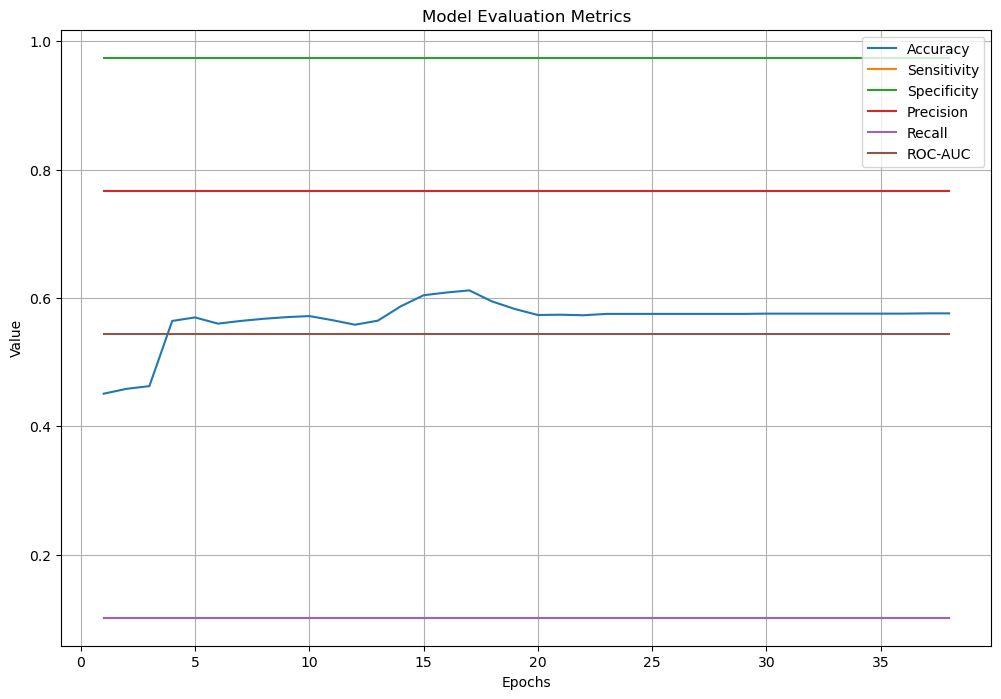

In [42]:
# Assuming y_train is one-dimensional (e.g., [0, 1, 0, 1, ...])
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=2)
X_train_flatten = X_train_processed.reshape((X_train_processed.shape[0], -1))

# Define the model
model_binary_crossentropy = Sequential()
model_binary_crossentropy.add(Dense(128, activation='relu', input_shape=(X_train_flatten.shape[1],)))
model_binary_crossentropy.add(Dense(64, activation='relu'))
model_binary_crossentropy.add(Dense(32, activation='relu'))
model_binary_crossentropy.add(Dense(16, activation='relu'))
model_binary_crossentropy.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
model_binary_crossentropy.compile(optimizer=optimizer, loss=custom_loss_v2, metrics=['accuracy'])

# Train the model
history_binary_crossentropy = model_binary_crossentropy.fit(X_train_flatten, y_train_one_hot, epochs=38, batch_size=32, validation_split=0.1)

# Define functions for evaluation metrics
def calculate_accuracy(model, data, labels, threshold):
    pred_probs = model.predict(data)
    pred_binary = (pred_probs[:, 1] > threshold).astype(int)
    accuracy = np.mean(pred_binary == labels)
    return accuracy

def calculate_sensitivity_specificity(model, data, labels, threshold):
    pred_binary = predict_with_threshold(model, data, threshold)
    conf_matrix = confusion_matrix(labels, pred_binary)
    TP = conf_matrix[1, 1]
    FN = conf_matrix[1, 0]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    return sensitivity, specificity

def calculate_precision_recall(model, data, labels, threshold):
    pred_binary = predict_with_threshold(model, data, threshold)
    conf_matrix = confusion_matrix(labels, pred_binary)
    TP = conf_matrix[1, 1]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0  
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0  
    
    return precision, recall

def calculate_roc_auc(model, data, labels):
    pred_probs = model.predict(data)  
    roc_auc = roc_auc_score(labels, pred_probs[:, 1])
    return roc_auc

# Calculate evaluation metrics after each epoch
epochs = range(1, len(history_binary_crossentropy.history['accuracy']) + 1)

accuracy_values = history_binary_crossentropy.history['accuracy']
sensitivity_values = []
specificity_values = []
precision_values = []
recall_values = []
roc_auc_values = []

threshold = 0.5

for epoch in epochs:
    sensitivity, specificity = calculate_sensitivity_specificity(model_binary_crossentropy, X_train_flatten, y_train, threshold)
    precision, recall = calculate_precision_recall(model_binary_crossentropy, X_train_flatten, y_train, threshold)
    roc_auc = calculate_roc_auc(model_binary_crossentropy, X_train_flatten, y_train)
    
    sensitivity_values.append(sensitivity)
    specificity_values.append(specificity)
    precision_values.append(precision)
    recall_values.append(recall)
    roc_auc_values.append(roc_auc)

# Plotting evaluation metrics over epochs
plt.figure(figsize=(12, 8))

plt.plot(epochs, accuracy_values, label='Accuracy')
plt.plot(epochs, sensitivity_values, label='Sensitivity')
plt.plot(epochs, specificity_values, label='Specificity')
plt.plot(epochs, precision_values, label='Precision')
plt.plot(epochs, recall_values, label='Recall')
plt.plot(epochs, roc_auc_values, label='ROC-AUC')

plt.title('Model Evaluation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()